<a href="https://colab.research.google.com/github/yongyong0514/paper/blob/main/Tbike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sea
from scipy import stats
import datetime

#그래프 그리기
%matplotlib inline

#그래프 가독성
plt.style.use('ggplot')

#마이너스 폰트 깨지는 것을 수정
#mpl.rcParams['axes.unicode_minus'] = False

In [59]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [60]:
#파일 가져오기
train = pd.read_csv("/content/gdrive/My Drive/PAPER/DATA/190410.csv", parse_dates=["started_at"])
train.shape

#CSV 파일 내부의 행 쌍따옴표 제거
def dequote(s):
    if (s[0] == s[-1]) and s.startswith(("'", '"')):
        return s[1:-1]
    return s

In [61]:
#CSV 파일의 컬럼 값 train.columns
#CSV 파일의 데이터 타입 값 train.dtypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334559 entries, 0 to 334558
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   started_at                 334559 non-null  datetime64[ns, UTC]
 1   ended_at                   334559 non-null  object             
 2   duration                   334559 non-null  int64              
 3   start_station_id           334559 non-null  int64              
 4   start_station_name         334559 non-null  object             
 5   start_station_description  333714 non-null  object             
 6   start_station_latitude     334559 non-null  float64            
 7   start_station_longitude    334559 non-null  float64            
 8   end_station_id             334559 non-null  int64              
 9   end_station_name           334559 non-null  object             
 10  end_station_description    334284 non-null  object      

In [62]:
#CSV 파일 하위 5개
train.tail()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
334554,2019-10-30 22:33:11.251000+00:00,2019-10-30 22:43:39.759000+00:00,628,46,Nidarø,ved rundkjøring utenfor Trondheim Spektrum,63.426462,10.378188,123,Hesthagen,Ved Klæbuveien,63.415418,10.399565
334555,2019-10-30 22:35:44.060000+00:00,2019-10-30 22:42:01.087000+00:00,377,30,St Olavs gate,Ved trikkeholdeplass,63.431171,10.390284,85,TMV-odden,Solsiden,63.435399,10.409983
334556,2019-10-30 22:39:20.876000+00:00,2019-10-30 22:47:35.547000+00:00,494,9,Brattørkaia,Ved hurtigbåtterminalen. Operativt betjeningsp...,63.437403,10.397294,65,Strandveikaia,langs Stiklestadveien ved Strandveien,63.442090,10.427939
334557,2019-10-30 22:48:01.228000+00:00,2019-10-30 22:50:39.349000+00:00,158,177,Kristiansten,langs Festningsgata mellom Holbergs gate og Ty...,63.425933,10.416602,21,Bakke bru,Ved holdeplass Bakkegata. Operativt betjenings...,63.432252,10.406996
334558,2019-10-30 22:55:55.520000+00:00,2019-10-30 23:09:44.779000+00:00,829,293,S. P. Andersens vei,ved Valgrindvegen,63.409888,10.405213,6,Lademoparken,ved kryss Mellomveien / Innherredsveien. Opera...,63.436605,10.425844


In [63]:
train.columns

Index(['started_at', 'ended_at', 'duration', 'start_station_id',
       'start_station_name', 'start_station_description',
       'start_station_latitude', 'start_station_longitude', 'end_station_id',
       'end_station_name', 'end_station_description', 'end_station_latitude',
       'end_station_longitude'],
      dtype='object')

In [64]:
#started_at 의 데이터를 시간별로 분류, 각 행을 하나로 카운트하는 rental 열 추가
train["rental"] = 1
train["year"] = train["started_at"].dt.year
train["month"] = train["started_at"].dt.month
train["day"] = train["started_at"].dt.day
train["hour"] = train["started_at"].dt.hour
train["aday"] = train["started_at"].dt.weekday

In [65]:
train.tail()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude,rental,year,month,day,hour,aday
334554,2019-10-30 22:33:11.251000+00:00,2019-10-30 22:43:39.759000+00:00,628,46,Nidarø,ved rundkjøring utenfor Trondheim Spektrum,63.426462,10.378188,123,Hesthagen,Ved Klæbuveien,63.415418,10.399565,1,2019,10,30,22,2
334555,2019-10-30 22:35:44.060000+00:00,2019-10-30 22:42:01.087000+00:00,377,30,St Olavs gate,Ved trikkeholdeplass,63.431171,10.390284,85,TMV-odden,Solsiden,63.435399,10.409983,1,2019,10,30,22,2
334556,2019-10-30 22:39:20.876000+00:00,2019-10-30 22:47:35.547000+00:00,494,9,Brattørkaia,Ved hurtigbåtterminalen. Operativt betjeningsp...,63.437403,10.397294,65,Strandveikaia,langs Stiklestadveien ved Strandveien,63.442090,10.427939,1,2019,10,30,22,2
334557,2019-10-30 22:48:01.228000+00:00,2019-10-30 22:50:39.349000+00:00,158,177,Kristiansten,langs Festningsgata mellom Holbergs gate og Ty...,63.425933,10.416602,21,Bakke bru,Ved holdeplass Bakkegata. Operativt betjenings...,63.432252,10.406996,1,2019,10,30,22,2
334558,2019-10-30 22:55:55.520000+00:00,2019-10-30 23:09:44.779000+00:00,829,293,S. P. Andersens vei,ved Valgrindvegen,63.409888,10.405213,6,Lademoparken,ved kryss Mellomveien / Innherredsveien. Opera...,63.436605,10.425844,1,2019,10,30,22,2


In [66]:
##null 값 체크
#train 데이터에서 started_at을 년,월,일,시간으로 나눈 후 각 단위마다 그룹화한 뒤, 그룹화된 단위의 수량을 체크
by_year = train.groupby('year').rental.sum()
by_month = train.groupby('month').rental.sum()
by_day = train.groupby('day').rental.sum()
by_hour = train.groupby('hour').rental.sum()

In [67]:
by_month

month
4     34793
5     49873
6     46624
7     37980
8     66119
9     55424
10    43746
Name: rental, dtype: int64

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, 'Hours')]

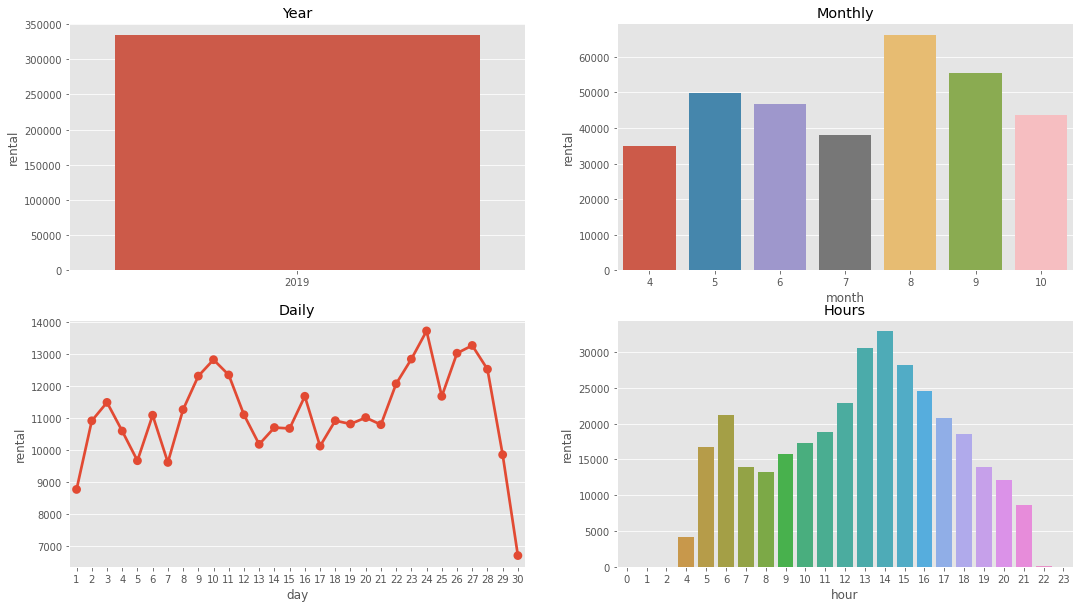

In [68]:
#기간별로 나눈 데이터를 통해 대여량 예측
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18,10)

sea.barplot(data=train, x=list(by_year.index.values.tolist()), y=by_year, ax=ax1)
sea.barplot(data=train, x=list(by_month.index.values.tolist()), y=by_month, ax=ax2)
sea.pointplot(data=train, x=list(by_day.index.values.tolist()), y=by_day, ax=ax3)
sea.barplot(data=train, x=list(by_hour.index.values.tolist()), y=by_hour, ax=ax4)

ax1.set(ylabel='rental', title="Year")
ax2.set(xlabel='month', title="Monthly")
ax3.set(xlabel='day', title="Daily")
ax4.set(xlabel='hour', title="Hours")


In [69]:
#각 달 데이터를 읽어서
#하나씩 그래프로 처리
#예) 데이터 내에서 4월 데이터만 추출, 4월의 시작점 순위를 5위까지
#랭크와 시작점 이름, 대여량을 순서대로 표시

#1. 데이터 내에서 month 열 내의 4월 데이터만 추출
#2. 4월 데이터 내에서 시작점 기준으로 정렬
#3. 정렬된 데이터에 넘버링 후 가로막대 그래프로 순위 표기
#4. 도착 포인트도 똑같이 구현해서 그래프 두개 가로 정렬

#다른 데이터 프레임을 최대한 이용하지 않고 train 내에서 해결 할 수 있또록 
#train -> 다른 데이터 시트 -> 다른 데이터 시트 -> 결과 x
#train - > 다른 데이터 시트 -> 결과 d

#시작
#숫자만 바뀌는 원리여서 for문 연구해보기

In [70]:
#정리된 csv에서 start 지점 isin의 속성 값으로 월을 입력받아 month에 해당 값을 필터링해 해당 달만 분리 train[train['month'].isin(['4'])]
#분리된 달 데이터에서 각각의 start_station_name으로 묶어 대여량을 카운트
#for monthly in range(1, 13):
#  exec("s%02d_19=train[train['month'].isin(['%02d'])]['start_station_name'].value_counts(normalize=False).head(5)" % (monthly, monthly))

In [71]:
#정리된 csv에서 end 지점 isin의 속성 값으로 월을 입력받아 month에 해당 값을 필터링해 해당 달만 분리
#분리된 달 데이터에서 각각의 end_station_name으로 묶어 대여량을 카운트
#for monthly in range(1, 13):
#  exec("e%02d_19 = train[train['month'].isin(['%02d'])]['end_station_name'].value_counts(normalize=False).head(5)" % (monthly, monthly))

In [72]:
#start_index와 value가 합쳐진 1차원 Series 값을 고유의 column index값을 가지는 DataFrame으로 변환
#for monthly in range(1, 13):
#  exec("slist_%02d_19 = pd.DataFrame({'Station':s%02d_19.index, 'Rental':s%02d_19.values})"% (monthly, monthly, monthly))

In [73]:
#end_index와 value가 합쳐진 1차원 Series 값을 고유의 column index값을 가지는 DataFrame으로 변환
#for monthly in range(1, 13):
#  exec("elist_%02d_19 = pd.DataFrame({'Station':e%02d_19.index, 'Rental':e%02d_19.values})"% (monthly, monthly, monthly))

In [74]:
#for monthly in range(1, 13):
#  exec("si%02d_19 = train[train['month'].isin(['%02d'])]['start_station_name'].value_counts(normalize = False).head(5)" % (monthly, monthly))

In [75]:
for monthly in range(1, 13):
  exec("s%02d_19 = train[train['month'].isin(['%02d'])]['start_station_name'].value_counts(normalize = False).head(5)" % (monthly, monthly))
  exec("e%02d_19 = train[train['month'].isin(['%02d'])]['end_station_name'].value_counts(normalize = False).head(5)" % (monthly, monthly))
  exec("slist_%02d_19 = pd.DataFrame({'Station':s%02d_19.index, 'Rental':s%02d_19.values})"% (monthly, monthly, monthly))
  exec("elist_%02d_19 = pd.DataFrame({'Station':e%02d_19.index, 'Rental':e%02d_19.values})"% (monthly, monthly, monthly))

In [76]:
s04_19

Bassengbakken    1711
Bakke bru        1333
Nordre gate      1331
Dokkparken       1288
Skansen          1241
Name: start_station_name, dtype: int64

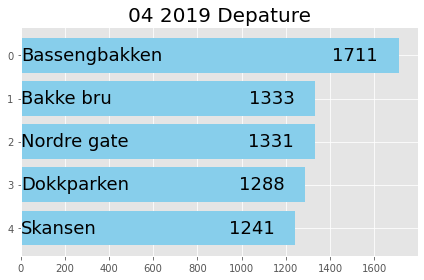

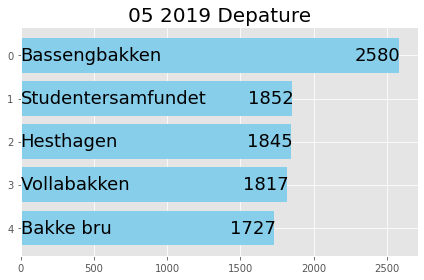

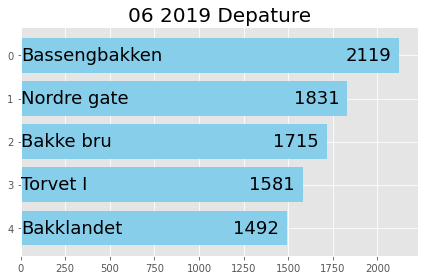

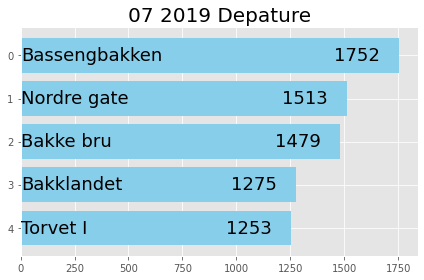

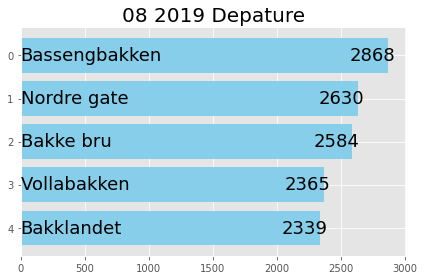

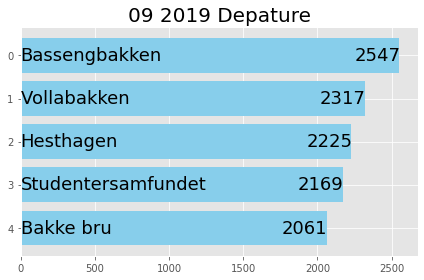

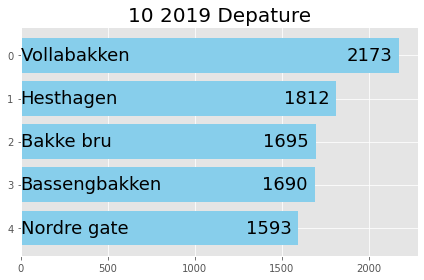

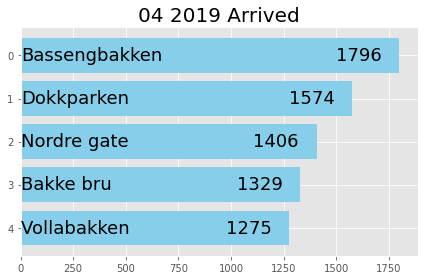

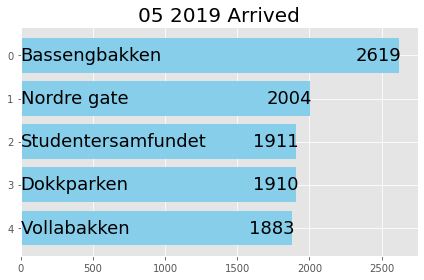

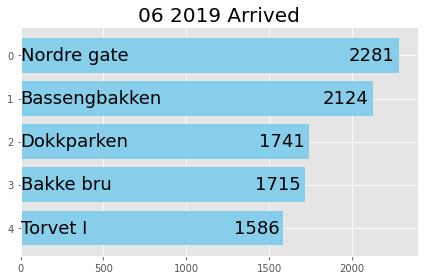

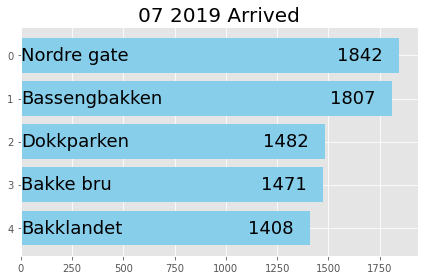

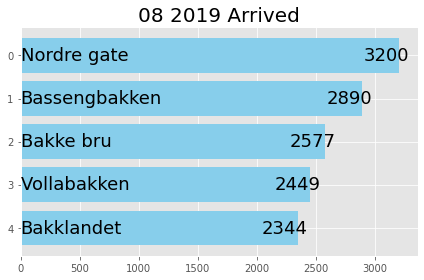

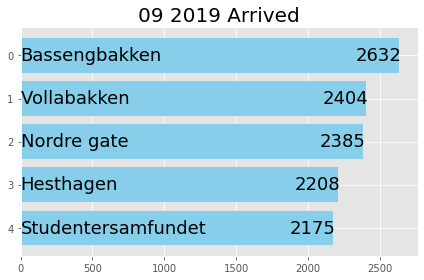

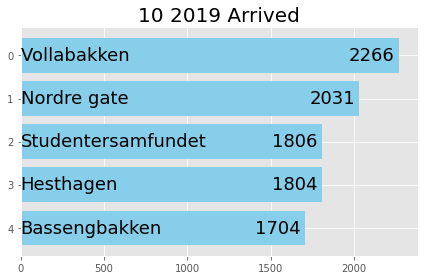

In [77]:
#정리된 CSV 목록 중에서 데이터가 없는 달을 제외, 그래프로 표기 하기 위해 준비
for monthly in range(1, 13):
  exec("filter1 = slist_%02d_19"% (monthly)) #가장 많이 출발하는 정거장
  if len(filter1) == 0: #len값이 0이면 무시한 뒤 else
    continue
  else: #데이터가 있는 달을 건네받아 그래프화
    exec("graph1 = slist_%02d_19.sort_values(by = ['Rental'], axis = 0)" % (monthly))
    graph1.plot(kind = "barh", legend = False, width = 0.8, color = 'skyblue')
    for i, (p, Rental) in enumerate(zip(graph1.Station, graph1.Rental)):
      plt.title("%02d 2019 Depature" %(monthly), size=20, color='black')
      plt.text(s = p, x = 1, y = i, color = "black", verticalalignment = "center", size = 18)
      plt.text(s = str(Rental), x = Rental-300, y = i, color = "black", verticalalignment = "center", horizontalalignment = "left", size = 18)
    #plt.axis("off")
    #plt.xticks([])
    #plt.yticks([])
    plt.tight_layout()
    plt.savefig("/content/gdrive/My Drive/PAPER/data1.png")


for monthly in range(1, 13):
  exec("filter2 = elist_%02d_19"% (monthly)) #가장 많이 도착하는 정거장
  if len(filter2) == 0: #len값이 0이면 무시한 뒤 else 
    continue
  else: #데이터가 있는 달을 건네받아 그래프화
    exec("graph2 = elist_%02d_19.sort_values(by = ['Rental'], axis = 0)" % (monthly))
    graph2.plot(kind = "barh", legend = False, width = 0.8, color = 'skyblue')
    for i, (p, Rental) in enumerate(zip(graph2.Station, graph2.Rental)):
      plt.title("%02d 2019 Arrived" %(monthly), size=20, color='black')
      plt.text(s = p, x = 1, y = i, color = "black", verticalalignment = "center", size = 18)
      plt.text(s = str(Rental), x = Rental-300, y = i, color = "black", verticalalignment = "center", horizontalalignment = "left", size = 18)
    #plt.axis("off")
    #plt.xticks([])
    #plt.yticks([])
    plt.tight_layout()
    plt.savefig("/content/gdrive/My Drive/PAPER/data2.png")
#폰트레이블
#font1 = {'family': 'NanumMyeongjo', 'size': 24, 
#         'color':  'black'}
#font2 = {'family': 'NanumBarunpen', 'size': 18, 'weight': 'bold',
#         'color':  'darkred'}
#font3 = {'family': 'NanumBarunGothic', 'size': 12, 'weight': 'light',
#         'color':  'blue'}

#plt.plot([10, 20, 30, 40], [1, 4, 9, 16])
#plt.title('한글 제목', fontdict=font1)
#plt.xlabel('엑스 축', fontdict=font2)
#plt.ylabel('와이 축', fontdict=font3)
#plt.show()


In [78]:
#그래프 반복문
#graph.plot(kind = "barh", legend = False, width = 0.8)
#for i, (p, Rental) in enumerate(zip(graph.Station, graph.Rental)):
#    plt.text(s = p, x = 1, y = i, color = "w", verticalalignment = "center", size = 18)
#    plt.text(s = str(Rental), x = Rental-300, y = i, color = "w", verticalalignment = "center", horizontalalignment = "left", size = 18)
#plt.axis("off")
#plt.xticks([])
#plt.yticks([])
#plt.tight_layout()
#plt.savefig("data.png")


[Text(0, 0.5, ''), Text(0.5, 1.0, '2019 Oct Arrived')]

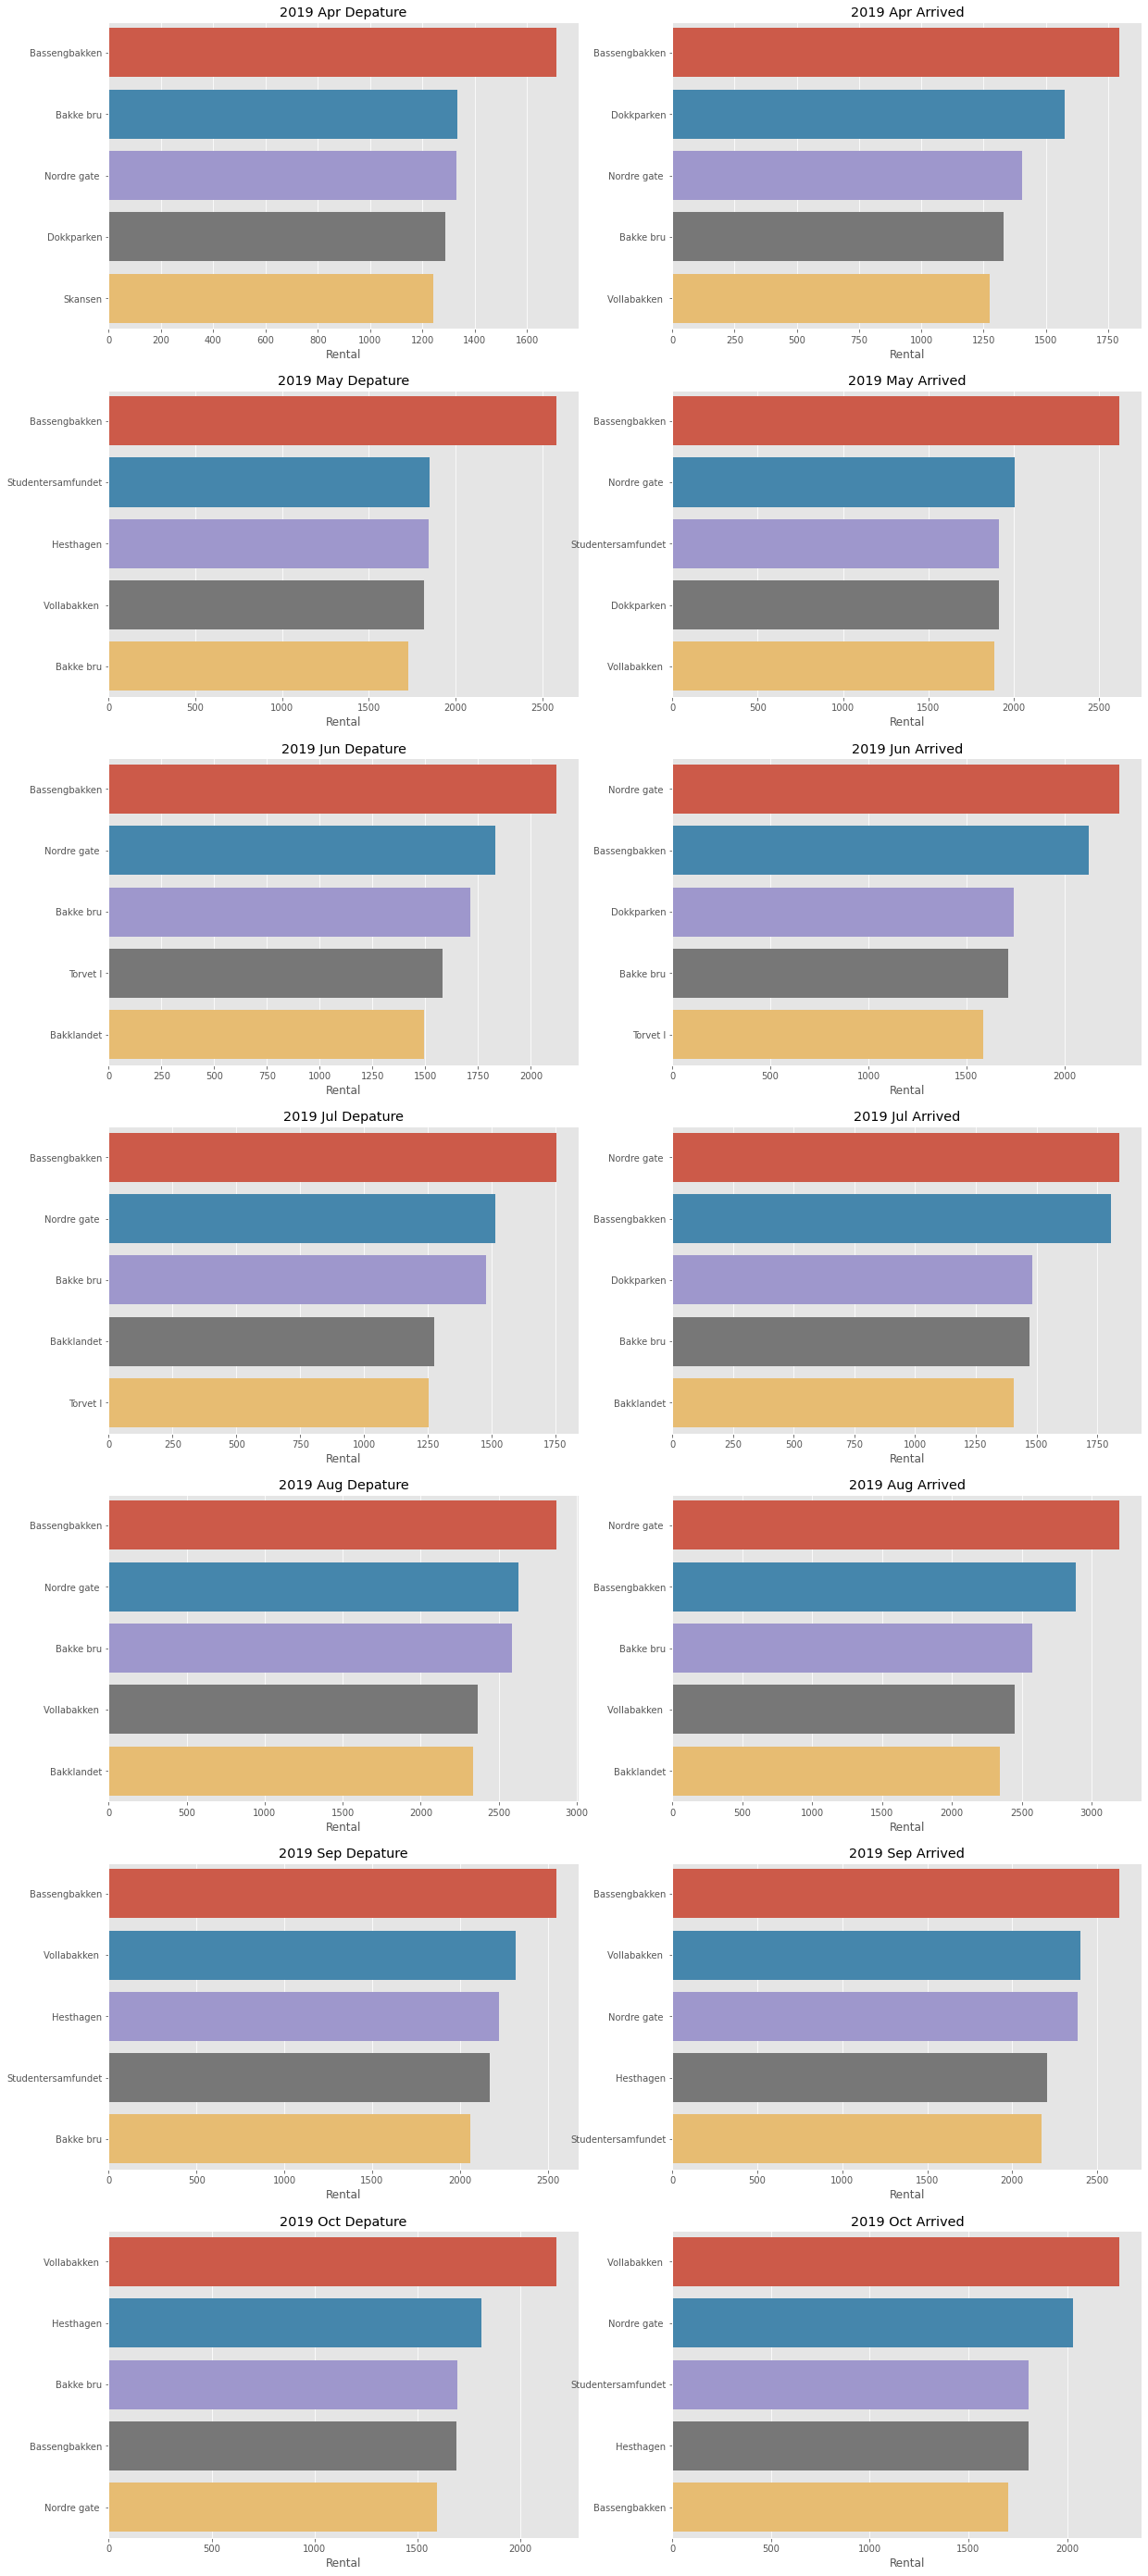

In [79]:
#분리된 해달 달의 수요 값을 가로 순위 그래프로 표현
#(ax19010, ax19011), (ax19020, ax19021), (ax19030, ax19031)
figure, ((ax19040, ax19041), (ax19050, ax19051), (ax19060, ax19061), (ax19070, ax19071), (ax19080, ax19081), (ax19090, ax19091), (ax19100, ax19101)) = plt.subplots(nrows = 7, ncols = 2)
figure.set_size_inches(20,50)

################################
## data = slist_01_19
## i = range (19 ~ 20)
## j = range (01 ~ 12)

## ax = as19010
## i = range 19010 ~ 19120
################################
#start
#sea.barplot(x = 'Rental',  y = 'Station', data = slist_01_19, orient = 'h', ax = ax19010)
#sea.barplot(x = 'Rental',  y = 'Station', data = slist_02_19, orient = 'h', ax = ax19020)
#sea.barplot(x = 'Rental',  y = 'Station', data = slist_03_19, orient = 'h', ax = ax19030)
sea.barplot(x = 'Rental',  y = 'Station', data = slist_04_19, orient = 'h', ax = ax19040)
sea.barplot(x = 'Rental',  y = 'Station', data = slist_05_19, orient = 'h', ax = ax19050)
sea.barplot(x = 'Rental',  y = 'Station', data = slist_06_19, orient = 'h', ax = ax19060)
sea.barplot(x = 'Rental',  y = 'Station', data = slist_07_19, orient = 'h', ax = ax19070)
sea.barplot(x = 'Rental',  y = 'Station', data = slist_08_19, orient = 'h', ax = ax19080)
sea.barplot(x = 'Rental',  y = 'Station', data = slist_09_19, orient = 'h', ax = ax19090)
sea.barplot(x = 'Rental',  y = 'Station', data = slist_10_19, orient = 'h', ax = ax19100)
#sea.barplot(x = 'Rental',  y = 'Station', data = slist_11_19, orient = 'h', ax = ax19110)
#sea.barplot(x = 'Rental',  y = 'Station', data = slist_12_19, orient = 'h', ax = ax19120)

################################
## ax = as19010
## i = range 19011 ~ 19121
################################
#end
#sea.barplot(x = 'Rental',  y= 'Station', data = elist_01_19, orient = 'h', ax = ax19011)
#sea.barplot(x = 'Rental',  y= 'Station', data = elist_02_19, orient = 'h', ax = ax19021)
#sea.barplot(x = 'Rental',  y= 'Station', data = elist_03_19, orient = 'h', ax = ax19031)
sea.barplot(x = 'Rental',  y= 'Station', data = elist_04_19, orient = 'h', ax = ax19041)
sea.barplot(x = 'Rental',  y= 'Station', data = elist_05_19, orient = 'h', ax = ax19051)
sea.barplot(x = 'Rental',  y= 'Station', data = elist_06_19, orient = 'h', ax = ax19061)
sea.barplot(x = 'Rental',  y= 'Station', data = elist_07_19, orient = 'h', ax = ax19071)
sea.barplot(x = 'Rental',  y= 'Station', data = elist_08_19, orient = 'h', ax = ax19081)
sea.barplot(x = 'Rental',  y= 'Station', data = elist_09_19, orient = 'h', ax = ax19091)
sea.barplot(x = 'Rental',  y= 'Station', data = elist_10_19, orient = 'h', ax = ax19101)
#sea.barplot(x = 'Rental',  y= 'Station', data = elist_11_19, orient = 'h', ax = ax19111)
#sea.barplot(x = 'Rental',  y= 'Station', data = elist_12_19, orient = 'h', ax = ax19121)

################################
## ax = as19010
## i = range 19011 ~ 19121

## ax = as19010
## i = range 19010 ~ 19120

## 2019 (month) Depature
## 2019 (month) Arrived
################################

#start
#ax19010.set(ylabel = None, title = "2019  Depature")
#ax19020.set(ylabel = None, title = "2019  Depature")
#ax19030.set(ylabel = None, title = "2019  Depature")
ax19040.set(ylabel = None, title = "2019 Apr Depature")
ax19050.set(ylabel = None, title = "2019 May Depature")
ax19060.set(ylabel = None, title = "2019 Jun Depature")
ax19070.set(ylabel = None, title = "2019 Jul Depature")
ax19080.set(ylabel = None, title = "2019 Aug Depature")
ax19090.set(ylabel = None, title = "2019 Sep Depature")
ax19100.set(ylabel = None, title = "2019 Oct Depature")
#ax19110.set(ylabel = None, title = "2019  Depature")
#ax19120.set(ylabel = None, title = "2019  Depature")

#end
#ax19011.set(ylabel = None, title = "2019  Arrived")
#ax19021.set(ylabel = None, title = "2019  Arrived")
#ax19031.set(ylabel = None, title = "2019  Arrived")
ax19041.set(ylabel = None, title = "2019 Apr Arrived")
ax19051.set(ylabel = None, title = "2019 May Arrived")
ax19061.set(ylabel = None, title = "2019 Jun Arrived")
ax19071.set(ylabel = None, title = "2019 Jul Arrived")
ax19081.set(ylabel = None, title = "2019 Aug Arrived")
ax19091.set(ylabel = None, title = "2019 Sep Arrived")
ax19101.set(ylabel = None, title = "2019 Oct Arrived")
#ax19111.set(ylabel = None, title = "2019  Arrived")
#ax19121.set(ylabel = None, title = "2019  Arrived")




#그래프 끝에 수치 표현 해결해야 함 brick = sea.barplot 식으로 
#for i in brick.patches:
#    width = i.get_width()
#    plt.text(1.05*i.get_width(), i.get_y()+0.5*i.get_height(), int(width), ha='center', va='center')



In [80]:
##2019년 04월부터 10월까지 시간 당 대여량 평균
#fig,(ax1) = plt.subplots(nrows=1)
#fig.set_size_inches(22,5)

#sea.pointplot(data=train, x=list(by_hour.index.values.tolist()), y=rental_sum_by_hour, ax=ax1)

In [81]:
 #이동거리예측 duration 값
#월간 가장 많이 간 루트  시작 - > 도착  수요량 및 소요시간 표시
# 3, 4, 5 봄
# 6, 7, 8 여름
# 9, 10, 11 가을
# 12, 1, 2 겨울

In [82]:
#si04_19 = train[train['month'].isin(['04'])] # 전체 CSV에서 month 기준 04월을 분류
#test1 = si04_19.sort_values(by='start_station_id', ascending=True) #분류된 4월 데이터에서 시작 정거장 기준 오름차순 정렬
# for sid in range(1, 294):# 시작 정거장 번호의 범위 1 ~ 293 정거장
#test2 = test1[test1['start_station_id'].isin(['01'])] # 분류된 4월 데이터에서 시작 정거장 1번 정거장 분류
#test3 = test2.sort_values(by='end_station_id', ascending=True) # 분류된 4월 데이터/1번 정거장 기준/도착 정거장을 오름차순 정렬
#test4 = test3['end_station_id'].value_counts(normalize=False).head(5)#도착 정거장 숫자 집계 내림차순(랭킹)

In [83]:
for monthly in range(1, 13):
  exec("si%02d_19 = train[train['month'].isin(['%02d'])]"%(monthly, monthly)) # 전체 CSV에서 month 기준 각 달 분류

In [84]:
for monthly in range(1, 13):
  if len("si%02d_19"% (monthly)) == 0: #len으로 값이 비었는지 검사 비었으면 무시 정거장 분류 전
    continue
  else:
    for ssid in range(1, 294): #해당 월에서 정거장 1 ~ 293까지 각각 분류하여 이름 저장 (비어있는 값에 대해선 카운트 안함)
      exec("ss%03d_%02d_19 = si%02d_19[si%02d_19['start_station_id'].isin(['%03d'])]" %(ssid, monthly, monthly, monthly, ssid)) #여기까지 해당 월의 각 시작지점이 하나씩 묶임 최대 5개
      if len("ss%03d_%02d_19"% (ssid, monthly)) == 0: #해당 월의 각 시작지점이 묶이 값을 하나씩 비어있는지 검사
        continue #비어있으면 무시 #시작 정거장을 각각으로 분류함
      else:
          exec("es%03d_%02d_19 = ss%03d_%02d_19['end_station_name'].value_counts(normalize=False).head(5)"% (ssid, monthly, ssid, monthly)) # ?월/?시작점에서 도착점 랭킹 및 수요
          if len("es%03d_%02d_19"% (ssid, monthly)) == 0:
            continue # 분리한 시작 정거장에서 도착 정거장을 그룹화해서 순위대로 표기, 상위 5개로 분류함
          else:
            exec("r%03d_%02d_19 = pd.DataFrame({'month':ss%03d_%02d_19['month'].head(), 'Depature': ss%03d_%02d_19['start_station_name'].head(), 'Arrived':es%03d_%02d_19.index, 'Rental1':es%03d_%02d_19.values})"%(ssid, monthly, ssid, monthly, ssid, monthly, ssid, monthly, ssid, monthly))
            if len("r%03d_%02d_19"% (ssid, monthly)) == 0:
              continue #분리한 시작 정거장에서 가장 많이 가는 도착 정거장 5가지로 데이터프레임을 생성
            else:
              pass
#그래프 구역(이전에 탑랭킹 뽑아야함

In [85]:
#달 범위 생성
for omg in range(1, 13):
    exec("rl_%02d_19 = pd.concat([r001_%02d_19, r002_%02d_19, r003_%02d_19, r004_%02d_19, r005_%02d_19, r006_%02d_19, r007_%02d_19, r008_%02d_19, r009_%02d_19, r010_%02d_19, r011_%02d_19, r012_%02d_19, r013_%02d_19, r014_%02d_19, r015_%02d_19, r016_%02d_19, r017_%02d_19, r018_%02d_19, r019_%02d_19, r020_%02d_19, r021_%02d_19, r022_%02d_19, r023_%02d_19, r024_%02d_19, r025_%02d_19, r026_%02d_19, r027_%02d_19, r028_%02d_19, r029_%02d_19, r030_%02d_19, r031_%02d_19, r032_%02d_19, r033_%02d_19, r034_%02d_19, r035_%02d_19, r036_%02d_19, r037_%02d_19, r038_%02d_19, r039_%02d_19, r040_%02d_19, r041_%02d_19, r042_%02d_19, r043_%02d_19, r044_%02d_19, r045_%02d_19, r046_%02d_19, r047_%02d_19, r048_%02d_19, r049_%02d_19, r050_%02d_19, r051_%02d_19, r052_%02d_19, r053_%02d_19, r054_%02d_19, r055_%02d_19, r056_%02d_19, r057_%02d_19, r058_%02d_19, r059_%02d_19, r060_%02d_19, r061_%02d_19, r062_%02d_19, r063_%02d_19, r064_%02d_19, r065_%02d_19, r066_%02d_19, r067_%02d_19, r068_%02d_19, r069_%02d_19, r070_%02d_19, r071_%02d_19, r072_%02d_19, r073_%02d_19, r074_%02d_19, r075_%02d_19, r076_%02d_19, r077_%02d_19, r078_%02d_19, r079_%02d_19, r080_%02d_19, r081_%02d_19, r082_%02d_19, r083_%02d_19, r084_%02d_19, r085_%02d_19, r086_%02d_19, r087_%02d_19, r088_%02d_19, r089_%02d_19, r090_%02d_19, r091_%02d_19, r092_%02d_19, r093_%02d_19, r094_%02d_19, r095_%02d_19, r096_%02d_19, r097_%02d_19, r098_%02d_19, r099_%02d_19, r100_%02d_19, r101_%02d_19, r102_%02d_19, r103_%02d_19, r104_%02d_19, r105_%02d_19, r106_%02d_19, r107_%02d_19, r108_%02d_19, r109_%02d_19, r110_%02d_19, r111_%02d_19, r112_%02d_19, r113_%02d_19, r114_%02d_19, r115_%02d_19, r116_%02d_19, r117_%02d_19, r118_%02d_19, r119_%02d_19, r120_%02d_19, r121_%02d_19, r122_%02d_19, r123_%02d_19, r124_%02d_19, r125_%02d_19, r126_%02d_19, r127_%02d_19, r128_%02d_19, r129_%02d_19, r130_%02d_19, r131_%02d_19, r132_%02d_19, r133_%02d_19, r134_%02d_19, r135_%02d_19, r136_%02d_19, r137_%02d_19, r138_%02d_19, r139_%02d_19, r140_%02d_19, r141_%02d_19, r142_%02d_19, r143_%02d_19, r144_%02d_19, r145_%02d_19, r146_%02d_19, r147_%02d_19, r148_%02d_19, r149_%02d_19, r150_%02d_19, r151_%02d_19, r152_%02d_19, r153_%02d_19, r154_%02d_19, r155_%02d_19, r156_%02d_19, r157_%02d_19, r158_%02d_19, r159_%02d_19, r160_%02d_19, r161_%02d_19, r162_%02d_19, r163_%02d_19, r164_%02d_19, r165_%02d_19, r166_%02d_19, r167_%02d_19, r168_%02d_19, r169_%02d_19, r170_%02d_19, r171_%02d_19, r172_%02d_19, r173_%02d_19, r174_%02d_19, r175_%02d_19, r176_%02d_19, r177_%02d_19, r178_%02d_19, r179_%02d_19, r180_%02d_19, r181_%02d_19, r182_%02d_19, r183_%02d_19, r184_%02d_19, r185_%02d_19, r186_%02d_19, r187_%02d_19, r188_%02d_19, r189_%02d_19, r190_%02d_19, r191_%02d_19, r192_%02d_19, r193_%02d_19, r194_%02d_19, r195_%02d_19, r196_%02d_19, r197_%02d_19, r198_%02d_19, r199_%02d_19, r200_%02d_19, r201_%02d_19, r202_%02d_19, r203_%02d_19, r204_%02d_19, r205_%02d_19, r206_%02d_19, r207_%02d_19, r208_%02d_19, r209_%02d_19, r210_%02d_19, r211_%02d_19, r212_%02d_19, r213_%02d_19, r214_%02d_19, r215_%02d_19, r216_%02d_19, r217_%02d_19, r218_%02d_19, r219_%02d_19, r220_%02d_19, r221_%02d_19, r222_%02d_19, r223_%02d_19, r224_%02d_19, r225_%02d_19, r226_%02d_19, r227_%02d_19, r228_%02d_19, r229_%02d_19, r230_%02d_19, r231_%02d_19, r232_%02d_19, r233_%02d_19, r234_%02d_19, r235_%02d_19, r236_%02d_19, r237_%02d_19, r238_%02d_19, r239_%02d_19, r240_%02d_19, r241_%02d_19, r242_%02d_19, r243_%02d_19, r244_%02d_19, r245_%02d_19, r246_%02d_19, r247_%02d_19, r248_%02d_19, r249_%02d_19, r250_%02d_19, r251_%02d_19, r252_%02d_19, r253_%02d_19, r254_%02d_19, r255_%02d_19, r256_%02d_19, r257_%02d_19, r258_%02d_19, r259_%02d_19, r260_%02d_19, r261_%02d_19, r262_%02d_19, r263_%02d_19, r264_%02d_19, r265_%02d_19, r266_%02d_19, r267_%02d_19, r268_%02d_19, r269_%02d_19, r270_%02d_19, r271_%02d_19, r272_%02d_19, r273_%02d_19, r274_%02d_19, r275_%02d_19, r276_%02d_19, r277_%02d_19, r278_%02d_19, r279_%02d_19, r280_%02d_19, r281_%02d_19, r282_%02d_19, r283_%02d_19, r284_%02d_19, r285_%02d_19, r286_%02d_19, r287_%02d_19, r288_%02d_19, r289_%02d_19, r290_%02d_19, r291_%02d_19, r292_%02d_19, r293_%02d_19])"% (omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg))

In [86]:
rl_04_19.sort_values('Rental1',ascending=False).head(5)
rl_05_19.sort_values('Rental1',ascending=False).head(5)
rl_06_19.sort_values('Rental1',ascending=False).head(5)
rl_07_19.sort_values('Rental1',ascending=False).head(5)
rl_08_19.sort_values('Rental1',ascending=False).head(5)
rl_09_19.sort_values('Rental1',ascending=False).head(5)
rl_10_19.sort_values('Rental1',ascending=False).head(5)

,month,Depature,Arrived,Rental1
290900,10,Vollabakken,Hesthagen,208
290864,10,Hesthagen,Lerkendal,206
290829,10,Lerkendal,Hesthagen,194
290901,10,Hesthagen,Vollabakken,169
290835,10,Lerkendal,Vollabakken,166


In [87]:
rl_04_19.sort_values('Rental1',ascending=False).head(5)

,month,Depature,Arrived,Rental1
105,4,Trikkestallen på Lademoen,Bassengbakken,154
121,4,Hesthagen,Lerkendal,148
150,4,Lerkendal,Hesthagen,146
45,4,Bassengbakken,Trikkestallen på Lademoen,142
212,4,Hesthagen,Vollabakken,102


In [88]:
rl_05_19.sort_values('Rental1',ascending=False).head(5)

,month,Depature,Arrived,Rental1
34821,5,Bassengbakken,Trikkestallen på Lademoen,219
34798,5,Trikkestallen på Lademoen,Bassengbakken,199
34817,5,Rosenborg skole,Gløshaugen,190
34801,5,Lerkendal,Hesthagen,183
34829,5,Hesthagen,Lerkendal,183


In [89]:
rl_06_19.sort_values('Rental1',ascending=False).head(5)

,month,Depature,Arrived,Rental1
84675,6,Trikkestallen på Lademoen,Bassengbakken,169
84694,6,Bassengbakken,Trikkestallen på Lademoen,154
84699,6,Bassengbakken,Nordre gate,151
84755,6,Hesthagen,Lerkendal,146
84771,6,Bakklandet,Bakklandet,142


In [90]:
rl_07_19.sort_values('Rental1',ascending=False).head(5)

,month,Depature,Arrived,Rental1
131295,7,Trikkestallen på Lademoen,Bassengbakken,179
131300,7,Bassengbakken,Trikkestallen på Lademoen,179
131348,7,Bakklandet,Bakklandet,157
131311,7,Bassengbakken,Nordre gate,115
131307,7,Thornesparken,Nordre gate,114


In [91]:
rl_08_19.sort_values('Rental1',ascending=False).head(5)

,month,Depature,Arrived,Rental1
169296,8,Lerkendal,Hesthagen,252
169321,8,Hesthagen,Lerkendal,232
169270,8,Trikkestallen på Lademoen,Bassengbakken,218
169271,8,Bassengbakken,Nordre gate,204
169275,8,Bassengbakken,Trikkestallen på Lademoen,192


In [92]:
rl_09_19.sort_values('Rental1',ascending=False).head(5)

,month,Depature,Arrived,Rental1
235407,9,Lerkendal,Hesthagen,223
235431,9,Hesthagen,Lerkendal,212
235512,9,Hesthagen,Vollabakken,185
235398,9,Vollabakken,Hesthagen,181
235399,9,Vollabakken,Bakke bru,172


In [93]:
rl_10_19.sort_values('Rental1',ascending=False).head(5)

,month,Depature,Arrived,Rental1
290900,10,Vollabakken,Hesthagen,208
290864,10,Hesthagen,Lerkendal,206
290829,10,Lerkendal,Hesthagen,194
290901,10,Hesthagen,Vollabakken,169
290835,10,Lerkendal,Vollabakken,166


In [94]:
#달 범위 생성
up0 = []
for i in range(1,293):
  up0.append(f"r{i:03}_%02d_19")
print("[{0}]".format( ', '.join(map(str, up0))))

[r001_%02d_19, r002_%02d_19, r003_%02d_19, r004_%02d_19, r005_%02d_19, r006_%02d_19, r007_%02d_19, r008_%02d_19, r009_%02d_19, r010_%02d_19, r011_%02d_19, r012_%02d_19, r013_%02d_19, r014_%02d_19, r015_%02d_19, r016_%02d_19, r017_%02d_19, r018_%02d_19, r019_%02d_19, r020_%02d_19, r021_%02d_19, r022_%02d_19, r023_%02d_19, r024_%02d_19, r025_%02d_19, r026_%02d_19, r027_%02d_19, r028_%02d_19, r029_%02d_19, r030_%02d_19, r031_%02d_19, r032_%02d_19, r033_%02d_19, r034_%02d_19, r035_%02d_19, r036_%02d_19, r037_%02d_19, r038_%02d_19, r039_%02d_19, r040_%02d_19, r041_%02d_19, r042_%02d_19, r043_%02d_19, r044_%02d_19, r045_%02d_19, r046_%02d_19, r047_%02d_19, r048_%02d_19, r049_%02d_19, r050_%02d_19, r051_%02d_19, r052_%02d_19, r053_%02d_19, r054_%02d_19, r055_%02d_19, r056_%02d_19, r057_%02d_19, r058_%02d_19, r059_%02d_19, r060_%02d_19, r061_%02d_19, r062_%02d_19, r063_%02d_19, r064_%02d_19, r065_%02d_19, r066_%02d_19, r067_%02d_19, r068_%02d_19, r069_%02d_19, r070_%02d_19, r071_%02d_19, r072_

In [95]:
#for as04 in range (1, 13):
#  exec("b%02d_19 = ")

In [96]:
#달 범위 생성
up0 = []
for i in range(1,294):
  up0.append(f"omg")
print("[{0}]".format( ', '.join(map(str, up0))))

[omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg,

In [97]:
#1. 달 범위 생성
mono=[]
for i in range(1, 294):
  mono.append(f"r{i:03}_%02d_19")
print("[{0}]".format( ', '.join(map(str, mono))))
#2. 아래 출력된 값을 복사

[r001_%02d_19, r002_%02d_19, r003_%02d_19, r004_%02d_19, r005_%02d_19, r006_%02d_19, r007_%02d_19, r008_%02d_19, r009_%02d_19, r010_%02d_19, r011_%02d_19, r012_%02d_19, r013_%02d_19, r014_%02d_19, r015_%02d_19, r016_%02d_19, r017_%02d_19, r018_%02d_19, r019_%02d_19, r020_%02d_19, r021_%02d_19, r022_%02d_19, r023_%02d_19, r024_%02d_19, r025_%02d_19, r026_%02d_19, r027_%02d_19, r028_%02d_19, r029_%02d_19, r030_%02d_19, r031_%02d_19, r032_%02d_19, r033_%02d_19, r034_%02d_19, r035_%02d_19, r036_%02d_19, r037_%02d_19, r038_%02d_19, r039_%02d_19, r040_%02d_19, r041_%02d_19, r042_%02d_19, r043_%02d_19, r044_%02d_19, r045_%02d_19, r046_%02d_19, r047_%02d_19, r048_%02d_19, r049_%02d_19, r050_%02d_19, r051_%02d_19, r052_%02d_19, r053_%02d_19, r054_%02d_19, r055_%02d_19, r056_%02d_19, r057_%02d_19, r058_%02d_19, r059_%02d_19, r060_%02d_19, r061_%02d_19, r062_%02d_19, r063_%02d_19, r064_%02d_19, r065_%02d_19, r066_%02d_19, r067_%02d_19, r068_%02d_19, r069_%02d_19, r070_%02d_19, r071_%02d_19, r072_

In [98]:
#3. pd.concat에 붙여넣기 해서 합침


In [99]:
#al_%02d_19 = pd.concat([r%03d_04_19])

#for omg in range(1, 13):
#    print("rl_%02d_19 = pd.concat([r%03d_%02d_19, r%03d_%02d_19])"% (omg, ))

In [100]:
#달 범위 생성
for omg in range(1, 13):
    exec("rl_%02d_19 = pd.concat([r001_%02d_19, r002_%02d_19, r003_%02d_19, r004_%02d_19, r005_%02d_19, r006_%02d_19, r007_%02d_19, r008_%02d_19, r009_%02d_19, r010_%02d_19, r011_%02d_19, r012_%02d_19, r013_%02d_19, r014_%02d_19, r015_%02d_19, r016_%02d_19, r017_%02d_19, r018_%02d_19, r019_%02d_19, r020_%02d_19, r021_%02d_19, r022_%02d_19, r023_%02d_19, r024_%02d_19, r025_%02d_19, r026_%02d_19, r027_%02d_19, r028_%02d_19, r029_%02d_19, r030_%02d_19, r031_%02d_19, r032_%02d_19, r033_%02d_19, r034_%02d_19, r035_%02d_19, r036_%02d_19, r037_%02d_19, r038_%02d_19, r039_%02d_19, r040_%02d_19, r041_%02d_19, r042_%02d_19, r043_%02d_19, r044_%02d_19, r045_%02d_19, r046_%02d_19, r047_%02d_19, r048_%02d_19, r049_%02d_19, r050_%02d_19, r051_%02d_19, r052_%02d_19, r053_%02d_19, r054_%02d_19, r055_%02d_19, r056_%02d_19, r057_%02d_19, r058_%02d_19, r059_%02d_19, r060_%02d_19, r061_%02d_19, r062_%02d_19, r063_%02d_19, r064_%02d_19, r065_%02d_19, r066_%02d_19, r067_%02d_19, r068_%02d_19, r069_%02d_19, r070_%02d_19, r071_%02d_19, r072_%02d_19, r073_%02d_19, r074_%02d_19, r075_%02d_19, r076_%02d_19, r077_%02d_19, r078_%02d_19, r079_%02d_19, r080_%02d_19, r081_%02d_19, r082_%02d_19, r083_%02d_19, r084_%02d_19, r085_%02d_19, r086_%02d_19, r087_%02d_19, r088_%02d_19, r089_%02d_19, r090_%02d_19, r091_%02d_19, r092_%02d_19, r093_%02d_19, r094_%02d_19, r095_%02d_19, r096_%02d_19, r097_%02d_19, r098_%02d_19, r099_%02d_19, r100_%02d_19, r101_%02d_19, r102_%02d_19, r103_%02d_19, r104_%02d_19, r105_%02d_19, r106_%02d_19, r107_%02d_19, r108_%02d_19, r109_%02d_19, r110_%02d_19, r111_%02d_19, r112_%02d_19, r113_%02d_19, r114_%02d_19, r115_%02d_19, r116_%02d_19, r117_%02d_19, r118_%02d_19, r119_%02d_19, r120_%02d_19, r121_%02d_19, r122_%02d_19, r123_%02d_19, r124_%02d_19, r125_%02d_19, r126_%02d_19, r127_%02d_19, r128_%02d_19, r129_%02d_19, r130_%02d_19, r131_%02d_19, r132_%02d_19, r133_%02d_19, r134_%02d_19, r135_%02d_19, r136_%02d_19, r137_%02d_19, r138_%02d_19, r139_%02d_19, r140_%02d_19, r141_%02d_19, r142_%02d_19, r143_%02d_19, r144_%02d_19, r145_%02d_19, r146_%02d_19, r147_%02d_19, r148_%02d_19, r149_%02d_19, r150_%02d_19, r151_%02d_19, r152_%02d_19, r153_%02d_19, r154_%02d_19, r155_%02d_19, r156_%02d_19, r157_%02d_19, r158_%02d_19, r159_%02d_19, r160_%02d_19, r161_%02d_19, r162_%02d_19, r163_%02d_19, r164_%02d_19, r165_%02d_19, r166_%02d_19, r167_%02d_19, r168_%02d_19, r169_%02d_19, r170_%02d_19, r171_%02d_19, r172_%02d_19, r173_%02d_19, r174_%02d_19, r175_%02d_19, r176_%02d_19, r177_%02d_19, r178_%02d_19, r179_%02d_19, r180_%02d_19, r181_%02d_19, r182_%02d_19, r183_%02d_19, r184_%02d_19, r185_%02d_19, r186_%02d_19, r187_%02d_19, r188_%02d_19, r189_%02d_19, r190_%02d_19, r191_%02d_19, r192_%02d_19, r193_%02d_19, r194_%02d_19, r195_%02d_19, r196_%02d_19, r197_%02d_19, r198_%02d_19, r199_%02d_19, r200_%02d_19, r201_%02d_19, r202_%02d_19, r203_%02d_19, r204_%02d_19, r205_%02d_19, r206_%02d_19, r207_%02d_19, r208_%02d_19, r209_%02d_19, r210_%02d_19, r211_%02d_19, r212_%02d_19, r213_%02d_19, r214_%02d_19, r215_%02d_19, r216_%02d_19, r217_%02d_19, r218_%02d_19, r219_%02d_19, r220_%02d_19, r221_%02d_19, r222_%02d_19, r223_%02d_19, r224_%02d_19, r225_%02d_19, r226_%02d_19, r227_%02d_19, r228_%02d_19, r229_%02d_19, r230_%02d_19, r231_%02d_19, r232_%02d_19, r233_%02d_19, r234_%02d_19, r235_%02d_19, r236_%02d_19, r237_%02d_19, r238_%02d_19, r239_%02d_19, r240_%02d_19, r241_%02d_19, r242_%02d_19, r243_%02d_19, r244_%02d_19, r245_%02d_19, r246_%02d_19, r247_%02d_19, r248_%02d_19, r249_%02d_19, r250_%02d_19, r251_%02d_19, r252_%02d_19, r253_%02d_19, r254_%02d_19, r255_%02d_19, r256_%02d_19, r257_%02d_19, r258_%02d_19, r259_%02d_19, r260_%02d_19, r261_%02d_19, r262_%02d_19, r263_%02d_19, r264_%02d_19, r265_%02d_19, r266_%02d_19, r267_%02d_19, r268_%02d_19, r269_%02d_19, r270_%02d_19, r271_%02d_19, r272_%02d_19, r273_%02d_19, r274_%02d_19, r275_%02d_19, r276_%02d_19, r277_%02d_19, r278_%02d_19, r279_%02d_19, r280_%02d_19, r281_%02d_19, r282_%02d_19, r283_%02d_19, r284_%02d_19, r285_%02d_19, r286_%02d_19, r287_%02d_19, r288_%02d_19, r289_%02d_19, r290_%02d_19, r291_%02d_19, r292_%02d_19, r293_%02d_19])"% (omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg, omg))

In [101]:

for otl in range(1, 13):
  exec(f"rl_{otl:02}_19.sort_values('Rental1',ascending=False).head(5)")


In [102]:
rl_04_19.sort_values('Rental1',ascending=False).head(5)

,month,Depature,Arrived,Rental1
105,4,Trikkestallen på Lademoen,Bassengbakken,154
121,4,Hesthagen,Lerkendal,148
150,4,Lerkendal,Hesthagen,146
45,4,Bassengbakken,Trikkestallen på Lademoen,142
212,4,Hesthagen,Vollabakken,102


In [103]:
rl_09_19.sort_values('Rental1',ascending=False).head(5)

,month,Depature,Arrived,Rental1
235407,9,Lerkendal,Hesthagen,223
235431,9,Hesthagen,Lerkendal,212
235512,9,Hesthagen,Vollabakken,185
235398,9,Vollabakken,Hesthagen,181
235399,9,Vollabakken,Bakke bru,172


In [104]:

a = []    # 빈 리스트 생성
 
#for i in range(10):
#    a.append(rl_%02_19)    # append로 요소 추가
#print(a)


In [105]:

a=[r001_04_19, r002_04_19, r003_04_19, r004_04_19]


as03=pd.concat(a,ignore_index=True)




In [106]:
pd.concat(a)

,month,Depature,Arrived,Rental1
84,4,Dokkparken,Nordre gate,71
151,4,Dokkparken,Bakklandet,69
154,4,Dokkparken,Vollabakken,64
195,4,Dokkparken,Cicignons plass,64
229,4,Dokkparken,Studentersamfundet,63
35,4,Dalen hageby,Lade idrettsanlegg vest,27
283,4,Dalen hageby,Dokkparken,26
1331,4,Dalen hageby,Lademoparken,23
1482,4,Dalen hageby,Håkon VIIs gate 8-10,22
2091,4,Dalen hageby,Bassengbakken,21


In [107]:
#a
#for monthly in range(1, 13):
#  for ssid in range(1, 294):
#    print(f"rm{monthly:02}_19 =")

In [108]:
#for monthly in range(1, 13):
#  exec("rl_%02d_19 = rl_0")

In [109]:
#for monthly in range(1, 13):
#  if len("rl_%02d_19"% (monthly)) == 0:
#    continue
#  else:
#    exec("rs%02d_19 = rl_%02d_19.sort_values('Rental1', ascending=False).head(5)"% (monthly))
#  if len("rs%02d_19"% (monthly)) == 0: #len으로 값이 비었는지 검사 비었으면 무시 정거장 분류 전
#    continue
#  else:
#    pass


In [110]:
  ####그래프샘플영역
  #exec("graph3 = r%03d_%02d_19.sort_values(by = ['Rental1'], axis = 0)"% (ssid, monthly))
              #graph.plot(kind = "barh", legend = False, width = 0.8)
              #for i, (p, Rental1) in enumerate(zip(graph3.Arrived, graph3.Rental1)):
                #plt.title("%02d 2019 Depature >>> Arrived" %(monthly), size=20, color='black')
                #plt.text(s = p, x = 1, y = i, color = "black", verticalalignment = "center", size = 18)
                #plt.text(s = str(Rental1), x = Rental-300, y = i, color = "black", verticalalignment = "center", horizontalalignment = "left", size = 18)
                #plt.axis("off")
                #plt.xticks([])
                #plt.yticks([])
                #plt.tight_layout()
                #plt.savefig("data1.png")

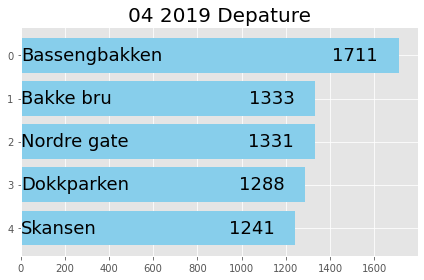

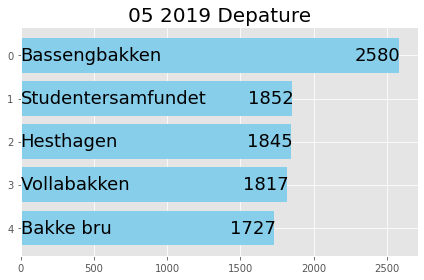

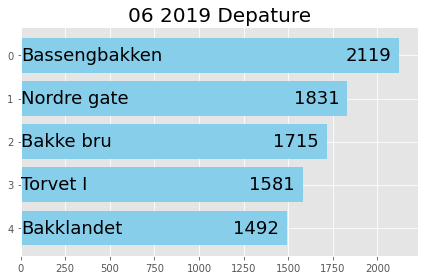

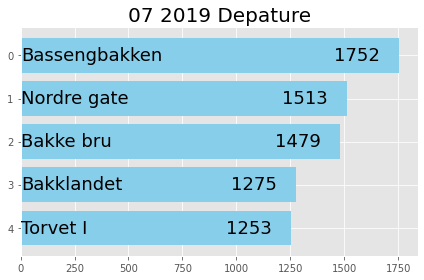

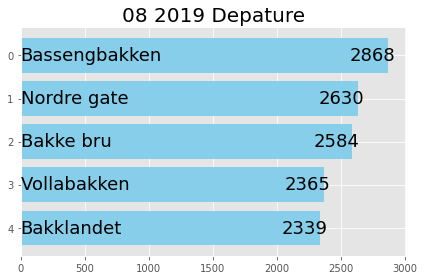

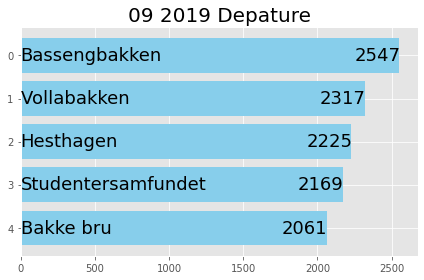

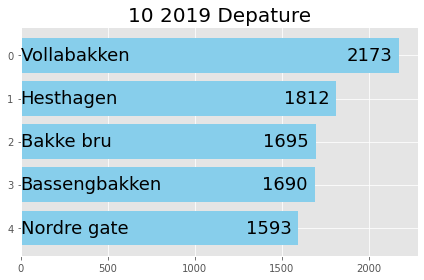

In [111]:
#정리된 CSV 목록 중에서 데이터가 없는 달을 제외, 그래프로 표기 하기 위해 준비
for monthly in range(1, 13):
  exec("filter1 = slist_%02d_19"% (monthly)) #가장 많이 출발하는 정거장
  if len(filter1) == 0: #len값이 0이면 무시한 뒤 else
    continue
  else: #데이터가 있는 달을 건네받아 그래프화
    exec("graph = slist_%02d_19.sort_values(by = ['Rental'], axis = 0)" % (monthly))
    graph.plot(kind = "barh", legend = False, width = 0.8, color = 'skyblue')
    for i, (p, Rental) in enumerate(zip(graph.Station, graph.Rental)):
      plt.title("%02d 2019 Depature" %(monthly), size=20, color='black')
      plt.text(s = p, x = 1, y = i, color = "black", verticalalignment = "center", size = 18)
      plt.text(s = str(Rental), x = Rental-300, y = i, color = "black", verticalalignment = "center", horizontalalignment = "left", size = 18)
    #plt.axis("off")
    #plt.xticks([])
    #plt.yticks([])
    plt.tight_layout()
    #plt.savefig("data1.png")

In [112]:
#test1 = si04_19.sort_values(by='start_station_id', ascending=True) #분류된 4월 데이터에서 시작 정거장 기준 오름차순 정렬
#test3 = test2.sort_values(by='end_station_id', ascending=True) # 분류된 4월 데이터/1번 정거장 기준/도착 정거장을 오름차순 정렬
# for sid in range(1, 294):# 시작 정거장 번호의 범위 1 ~ 293 정거장
#-------------

#si04_19 = train[train['month'].isin(['04'])] # 전체 CSV에서 month 기준 04월을 분류
#test2 = si04_19[si04_19['start_station_id'].isin(['01'])] # 분류된 4월 데이터에서 시작 정거장 1번 정거장 분류
#test3 = test2['end_station_id'].value_counts(normalize=False).head(1)#도착 정거장 숫자 집계 내림차순(랭킹)
#4월 데이터에서 시작정거장 1번 기준/가장 많이 도착하는 도착 정거장 20번 71
#4월 데이터에서 시작정거장 2번 기준/가장 많이 도착하는 도착 정거장

#for monthly in range(1, 13):
#  exec("si%02d_19 = train[train['month'].isin(['%02d'])]"%(monthly)) # 전체 CSV에서 month 기준 각 달 분류

#for monthly in range(1, 13):
#  exec("filter3 = si%02d_19"% monthly) #각 월을 선택 후
#  if len(filter3) == 0: #len으로 값이 비었는지 검사 비었으면 무시
#    continue
#  else:

#이걸 for문 돌리면
#ss04_19 = si04_19[si04_19['start_station_id'].isin(['01'])] # 분류된 4월 데이터에서 시작 정거장 1번 정거장 분류
#ss04_19 = si04_19[si04_19['start_station_id'].isin(['02'])] # 분류된 4월 데이터에서 시작 정거장 2번 정거장 분류
#ss04_19 = si04_19[si04_19['start_station_id'].isin(['03'])] # 분류된 4월 데이터에서 시작 정거장 3번 정거장 분류
#ss04_19 = si04_19[si04_19['start_station_id'].isin(['222'])] # 분류된 4월 데이터에서 시작 정거장 222번 정거장 분류


#test3 = test2['end_station_id'].value_counts(normalize=False).head(1)#도착 정거장 숫자 집계 내림차순(랭킹)

#...
#줄임
#si04_19 = train[train['month'].isin(['04'])] # 전체 CSV에서 month 기준 04월을 분류
#ss04_19 = si04_19[si04_19['start_station_id'].isin(['01'])]['end_station_id'].value_counts(normalize=False).head(1)#도착 정거장 숫자 집계 내림차순(랭킹)


#4월 데이터에서 시장정거장 293번 기준/가장 많이 도착하는 도착 정거장 for문 사용 구현
#코드 축약
#for문으로 전체 CSV에서 month 기준으로 각 월을 분류함
#for monthly in range(1, 13):
#  exec("si%02d_19 = train[train['month'].isin(['%02d'])]" % (monthly, monthly)) # 전체 CSV에서 month 기준 04월을 분류

#for문으로 전체 CSV에서 분류된 월을 스테이션 번호별(1~293)로 도착정거장 숫자 집계
#  for station_num in range(1, 294):
#    exec("ss_%02d_19 = si%02d_19[si%02d_19['start_station_id'].isin(['%02d'])]['end_station_id'].value_counts(normalize=False).head(1)" % (monthly, monthly, monthly, station_num))#도착 정거장 숫자 집계 내림차순(랭킹)

##값이 없으면 지나가는 반복문(대입필요)
#for monthly in range(1, 13):
#  exec("filter2 = si%02d_19"% (monthly)) #전체 CSV에서 4월을 분류한 값
#  if len(filter2) == 0: #len값이 0이면 무시한 뒤 else 
#    continue
#  else: #데이터가 있는 달을 건네받아 그래프화


In [113]:
by_month.values

array([34793, 49873, 46624, 37980, 66119, 55424, 43746])

In [119]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
 
monthly = [by_month.index]# 자전거 대여 달
rental = [by_month.values]# 달마다 총 대여량
W = tf.Variable(tf.random_uniform([1], -100, 100))# 가중치 설정 100 단위
b = tf.Variable(tf.random_uniform([1], -100, 100))# 렌덤 값으로 가중치를 조절 1차원 배열에 삽입
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)
H = W * X + b # 가설식
cost = tf.reduce_mean(tf.square(H - Y))# 비용 함수
a = tf.Variable(0.01)# 경사하강 설정
optimizer = tf.train.GradientDescentOptimizer(a)# 텐서플로우 경사하강 라이브러리
train = optimizer.minimize(cost)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

 
 
for i in range(10001): #
    sess.run(train, feed_dict={X: monthly, Y: rental})
    if i% 500 == 0: # 500개 마다 모니터링
        print (i, sess.run(cost, feed_dict={X: monthly, Y: rental}), sess.run(W), sess.run(b))

print (sess.run(H, feed_dict={X: [8]}))# 다음달 수요 예측



Instructions for updating:
non-resource variables are not supported in the long term
0 174095440.0 [6856.8545] [911.1007]
500 98663280.0 [4103.448] [17919.488]
1000 84620104.0 [3028.5156] [26046.871]
1500 81438100.0 [2516.835] [29915.604]
2000 80717064.0 [2273.2659] [31757.19]
2500 80553690.0 [2157.326] [32633.791]
3000 80516680.0 [2102.1367] [33051.066]
3500 80508296.0 [2075.8674] [33249.688]
4000 80506410.0 [2063.3625] [33344.234]
4500 80505960.0 [2057.4104] [33389.24]
5000 80505864.0 [2054.5767] [33410.66]
5500 80505850.0 [2053.223] [33420.9]
6000 80505840.0 [2052.5874] [33425.703]
6500 80505840.0 [2052.296] [33427.906]
7000 80505860.0 [2052.1694] [33428.86]
7500 80505860.0 [2052.1694] [33428.86]
8000 80505860.0 [2052.1694] [33428.86]
8500 80505860.0 [2052.1694] [33428.86]
9000 80505860.0 [2052.1694] [33428.86]
9500 80505860.0 [2052.1694] [33428.86]
10000 80505860.0 [2052.1694] [33428.86]
[49846.215]


In [120]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
 
monthly = [by_month.index]# 자전거 대여 달
rental = [by_month.values]# 달마다 총 대여량
W = tf.Variable(tf.random_uniform([1], -100, 100))# 가중치 설정 100 단위
b = tf.Variable(tf.random_uniform([1], -100, 100))# 렌덤 값으로 가중치를 조절 1차원 배열에 삽입
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)
H = W * X + b # 가설식
cost = tf.reduce_mean(tf.square(H - Y))# 비용 함수
a = tf.Variable(0.01)# 경사하강 설정
optimizer = tf.train.GradientDescentOptimizer(a)# 텐서플로우 경사하강 라이브러리
train = optimizer.minimize(cost)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

 
 
for i in range(10001): #
    sess.run(train, feed_dict={X: monthly, Y: rental})
    if i% 500 == 0: # 500개 마다 모니터링
        print (i, sess.run(cost, feed_dict={X: monthly, Y: rental}), sess.run(W), sess.run(b))

print (sess.run(H, feed_dict={X: [8]}))# 다음달 수요 예측


0 173806260.0 [6846.9736] [1020.028]
500 98542780.0 [4096.6294] [17971.045]
1000 84592824.0 [3025.271] [26071.404]
1500 81431890.0 [2515.291] [29927.28]
2000 80715670.0 [2272.5317] [31762.738]
2500 80553384.0 [2156.9768] [32636.434]
3000 80516616.0 [2101.972] [33052.312]
3500 80508280.0 [2075.7888] [33250.277]
4000 80506390.0 [2063.3264] [33344.508]
4500 80505944.0 [2057.3923] [33389.375]
5000 80505864.0 [2054.5688] [33410.72]
5500 80505840.0 [2053.2188] [33420.926]
6000 80505840.0 [2052.5857] [33425.72]
6500 80505816.0 [2052.295] [33427.914]
7000 80505860.0 [2052.1694] [33428.86]
7500 80505860.0 [2052.1694] [33428.86]
8000 80505860.0 [2052.1694] [33428.86]
8500 80505860.0 [2052.1694] [33428.86]
9000 80505860.0 [2052.1694] [33428.86]
9500 80505860.0 [2052.1694] [33428.86]
10000 80505860.0 [2052.1694] [33428.86]
[49846.215]
